<a href="https://colab.research.google.com/github/wjung1008/License_plate_recognition/blob/main/Ontario_License_plate_recognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Source Code:
https://github.com/kairess/license_plate_recognition


### Import neccessary packages

pytesseract is used to read the license number from the image (it'll be installed if not already from the code below)

In [114]:
try:
    import pytesseract
    pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'

except ModuleNotFoundError:
    !pip install pytesseract
    !sudo apt install tesseract-ocr
    !sudo apt-get install tesseract-ocr-eng
    import pytesseract
    pytesseract.pytesseract.tesseract_cmd = r'/usr/bin/tesseract'


In [116]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.style.use('dark_background')

## Import sample image

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


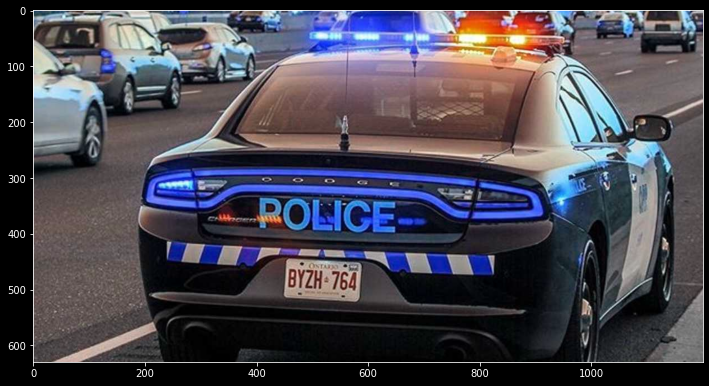

In [117]:
from google.colab import drive
drive.mount('/content/gdrive')

file = '/content/gdrive/MyDrive/License_plate/sample.jpg'


img_ori = cv2.imread(file)

height, width, channel = img_ori.shape

plt.figure(figsize=(12, 10))
plt.imshow(img_ori, cmap='gray')



## Convert Image to Grayscale

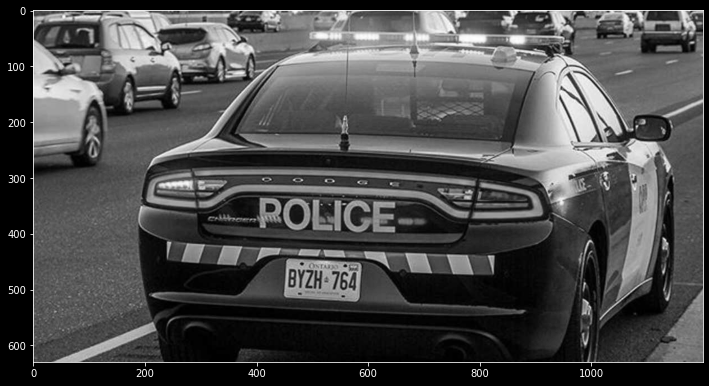

In [118]:
gray = cv2.cvtColor(img_ori, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(12, 10))
plt.imshow(gray, cmap='gray')

## Adaptive Thresholding
- Gaussian blur is used to remove noises.
- Adaptive threshold sets up a threshold value to binarize the image.

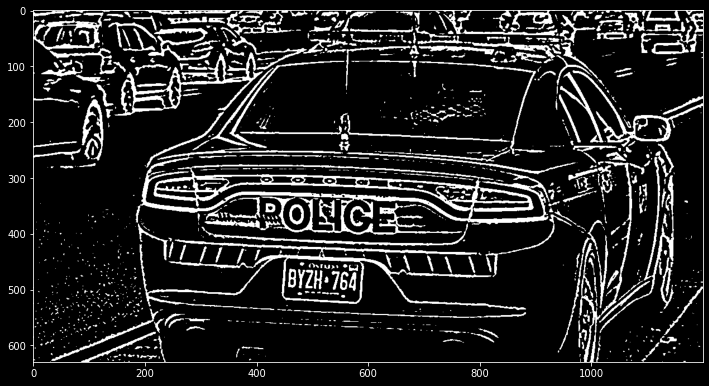

In [119]:
img_blurred = cv2.GaussianBlur(gray, ksize=(7, 7), sigmaX=1)

img_thresh = cv2.adaptiveThreshold(
    img_blurred, 
    maxValue=255.0, 
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C, 
    thresholdType=cv2.THRESH_BINARY_INV, 
    blockSize=19, 
    C=9
)

plt.figure(figsize=(12, 10))
plt.imshow(img_thresh, cmap='gray')

## Find Contours
1.  Contours are found using cv2.findContours.
2. Found contours are drawn using cv2.drawContours

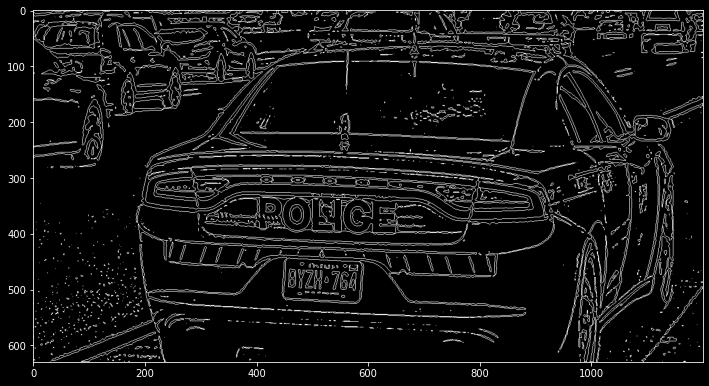

In [120]:
contours, _ = cv2.findContours(
    img_thresh, 
    mode=cv2.RETR_LIST, 
    method=cv2.CHAIN_APPROX_SIMPLE)

temp_result = np.zeros((height, width, channel), dtype=np.uint8)

cv2.drawContours(temp_result, contours=contours, contourIdx=-1, color=(255, 255, 255))

plt.figure(figsize=(12, 10))
plt.imshow(temp_result)

## Set up bounding boxes around the contour lines
1. Make a bounding box around the contours using cv2.boundingRect
2. These bounding boxes are saved on contours_dict

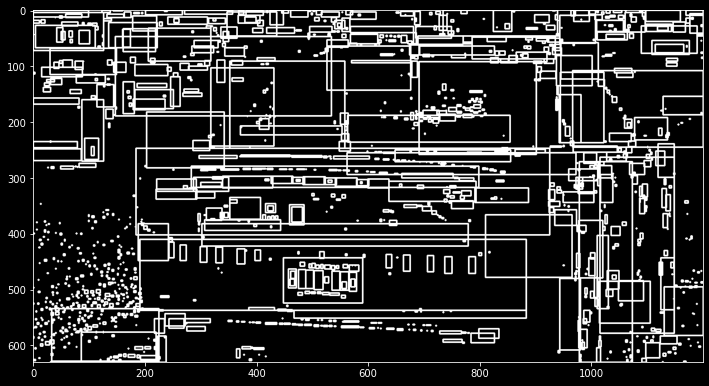

In [121]:
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

contours_dict = []

for contour in contours:
    x, y, w, h = cv2.boundingRect(contour)
    cv2.rectangle(temp_result, pt1=(x, y), pt2=(x+w, y+h), color=(255, 255, 255), thickness=2)
    
    # insert to dict
    contours_dict.append({
        'contour': contour,
        'x': x,
        'y': y,
        'w': w,
        'h': h,
        'cx': x + (w / 2),
        'cy': y + (h / 2)
    })

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

## Select possible candidates for the license number
- Find approximate shape of the possible license number using the area and ratio of the bounding box.
- Then, only show possible candidates for the license number.

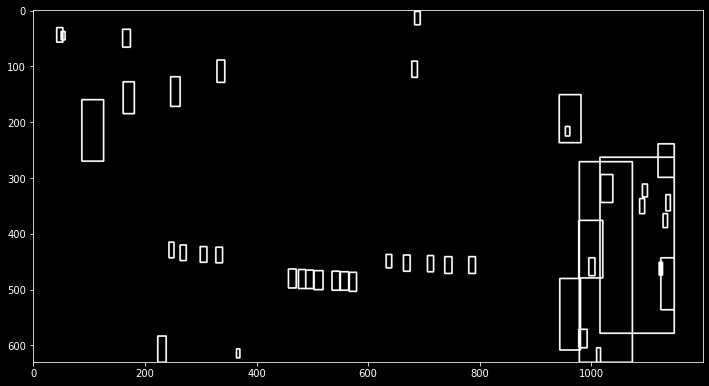

In [127]:
MIN_AREA = 80
MIN_WIDTH, MIN_HEIGHT = 2, 8
MIN_RATIO, MAX_RATIO = 0.25, 0.5

possible_contours = []

cnt = 0
for d in contours_dict:
    area = d['w'] * d['h']
    ratio = d['w'] / d['h']
    
    if area > MIN_AREA \
    and d['w'] > MIN_WIDTH and d['h'] > MIN_HEIGHT \
    and MIN_RATIO < ratio < MAX_RATIO:
        d['idx'] = cnt
        cnt += 1
        possible_contours.append(d)
        
# visualize possible contours
temp_result = np.zeros((height, width, channel), dtype=np.uint8)

for d in possible_contours:
#     cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
    cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

## Select Candidates by Arrangement of Contours
- From the possible candidates, filter them once more using the pattern of those bounding boxes.

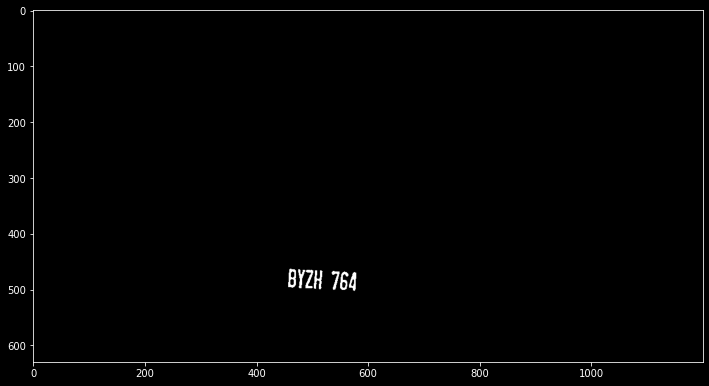

In [144]:
MAX_DIAG_MULTIPLYER = 3 # distance between bounding boxes
MAX_ANGLE_DIFF = 10.0 # angular difference between two bounding boxes
MAX_AREA_DIFF = 0.3 # area difference between two bounding boxes
MAX_WIDTH_DIFF = 0.5 # width difference between two bounding boxes
MAX_HEIGHT_DIFF = 0.2 # height difference between two bounding boxes
MIN_N_MATCHED = 6 # minimum number of consequent candidates

def find_chars(contour_list):
    matched_result_idx = []
    
    for d1 in contour_list:
        matched_contours_idx = []

        # If idx is identical, skip
        for d2 in contour_list:
            if d1['idx'] == d2['idx']:
                continue

            # Find dx and dy between the bounding boxes w.r.t its center
            dx = abs(d1['cx'] - d2['cx'])
            dy = abs(d1['cy'] - d2['cy'])

            # Compute the distance between the bounding boxes
            diagonal_length1 = np.sqrt(d1['w'] ** 2 + d1['h'] ** 2)

            distance = np.linalg.norm(np.array([d1['cx'], d1['cy']]) - np.array([d2['cx'], d2['cy']]))
            if dx == 0:
                angle_diff = 90
            else:
                angle_diff = np.degrees(np.arctan(dy / dx)) # compute the angular difference between the bounding boxes
            area_diff = abs(d1['w'] * d1['h'] - d2['w'] * d2['h']) / (d1['w'] * d1['h'])
            width_diff = abs(d1['w'] - d2['w']) / d1['w']
            height_diff = abs(d1['h'] - d2['h']) / d1['h']

            if distance < diagonal_length1 * MAX_DIAG_MULTIPLYER \
            and angle_diff < MAX_ANGLE_DIFF and area_diff < MAX_AREA_DIFF \
            and width_diff < MAX_WIDTH_DIFF and height_diff < MAX_HEIGHT_DIFF:
                matched_contours_idx.append(d2['idx'])

        # append this contour
        matched_contours_idx.append(d1['idx'])

        # Check if the number of matched contours are more than min # of consequent candidates
        if len(matched_contours_idx) < MIN_N_MATCHED:
            continue

        matched_result_idx.append(matched_contours_idx)

        # Double check unmatched contours, just in case
        unmatched_contour_idx = []
        for d4 in contour_list:
            if d4['idx'] not in matched_contours_idx:
                unmatched_contour_idx.append(d4['idx'])

        unmatched_contour = np.take(possible_contours, unmatched_contour_idx)
        
        # recursive
        recursive_contour_list = find_chars(unmatched_contour)
        
        for idx in recursive_contour_list:
            matched_result_idx.append(idx)

        break

    return matched_result_idx
    
result_idx = find_chars(possible_contours)

matched_result = []
for idx_list in result_idx:
    matched_result.append(np.take(possible_contours, idx_list))

# visualize possible contours
temp_result = np.zeros((height, width), dtype=np.uint8)



for r in matched_result:
    for d in r:
        # cv2.drawContours(temp_result, d['contour'], -1, (255, 255, 255))
        temp_result[d['y']:d['y']+d['h'],d['x']:d['x']+d['w']] = img_thresh[d['y']:d['y']+d['h'],d['x']:d['x']+d['w']]
        # cv2.rectangle(temp_result, pt1=(d['x'], d['y']), pt2=(d['x']+d['w'], d['y']+d['h']), color=(255, 255, 255), thickness=2)

plt.figure(figsize=(12, 10))
plt.imshow(temp_result, cmap='gray')

## Crop the detected license plate from the image
- cv2.getRectSubPix function used to crop the image


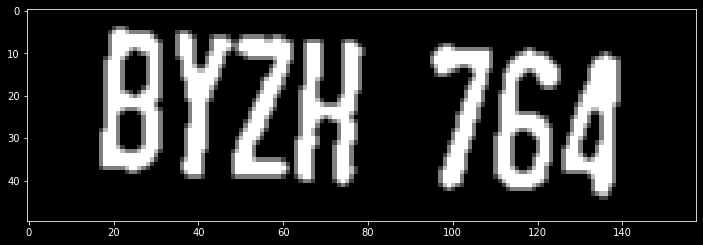

In [140]:
PLATE_WIDTH_PADDING = 1.3
PLATE_HEIGHT_PADDING = 1.5
MIN_PLATE_RATIO = 3
MAX_PLATE_RATIO = 10

plate_imgs = []
plate_infos = []

for i, matched_chars in enumerate(matched_result):
    sorted_chars = sorted(matched_chars, key=lambda x: x['cx'])
    plate_cx = (sorted_chars[0]['cx'] + sorted_chars[-1]['cx']) / 2
    plate_cy = (sorted_chars[0]['cy'] + sorted_chars[-1]['cy']) / 2
    
    plate_width = (sorted_chars[-1]['x'] + sorted_chars[-1]['w'] - sorted_chars[0]['x']) * PLATE_WIDTH_PADDING
    
    sum_height = 0
    for d in sorted_chars:
        sum_height += d['h']

    plate_height = int(sum_height / len(sorted_chars) * PLATE_HEIGHT_PADDING)
    
img_cropped = cv2.getRectSubPix(temp_result, patchSize=(int(plate_width), int(plate_height)),center=(int(plate_cx), int(plate_cy)))
plt.figure(figsize=(12, 10))
plt.imshow(img_cropped, cmap='gray')

# Another Threshold to refine the cropped license plate
- From the refined cropped license plate, use pytesseract.image_to_string to read the string from the image.
- If eng language cannot be read, download the eng.traineddata (default language is set to English)
- https://github.com/tesseract-ocr/tessdata/blob/master/eng.traineddata

BYZH 764



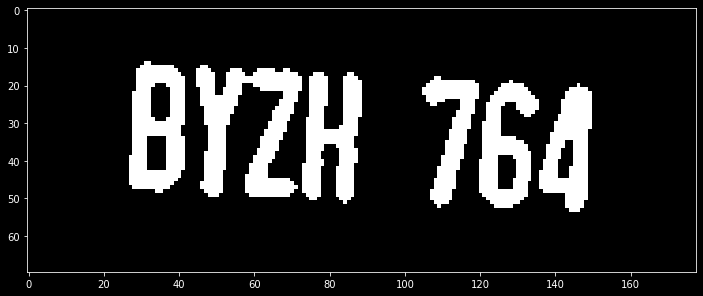

In [141]:
img_result = cv2.GaussianBlur(img_cropped, ksize=(3, 3), sigmaX=0)
_, img_result = cv2.threshold(img_result, thresh=0.0, maxval=255.0, type=cv2.THRESH_BINARY | cv2.THRESH_OTSU)
img_result = cv2.copyMakeBorder(img_result, top=10, bottom=10, left=10, right=10, borderType=cv2.BORDER_CONSTANT, value=(0,0,0))

plt.figure(figsize=(12, 10))
plt.imshow(img_result, cmap='gray')

chars = pytesseract.image_to_string(img_result, config='--psm 7 --oem 0')
print(chars)


# pytessreact successfully read the detected license plate from the image above.